In [9]:
import math
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import savgol_filter


In [10]:
def zero_pad(Y):
    mx, my = Y.shape
    padded_x = ((mx + 7) // 8) * 8
    padded_y = ((my + 7) // 8) * 8
    img = np.zeros((padded_x, padded_y), dtype=np.uint8)
    img[:mx, :my] = Y

    return img

def DCT(img):
    w, h = img.shape
    num_blocks = (w // 8) * (h // 8)
    dct_output = np.zeros((8, 8, num_blocks), dtype=float)

    for ci, (i, j) in enumerate((x, y) for x in range(0, w, 8) for y in range(0, h, 8)):
        dct_output[:, :, ci] = cv2.dct(img[i:i+8, j:j+8].astype(np.float32))  # Ensure input is float for DCT

    return dct_output


def hist(DC, N=2000, show=False):
    hcount, bin_edges = np.histogram(DC, bins=N, density=True)
    if show:
        plt.figure(figsize=(10, 6))
        sns.histplot(x=bin_edges[:-1], weights=hcount, bins=N, kde=True, stat="density")
        plt.title("DC Coefficient Histogram")
        plt.xlabel("DC Coefficient Value")
        plt.ylabel("Density")
        plt.show()
    return hcount, bin_edges

def FFT(hcount):
  hcount -= np.mean(hcount)
  x = np.fft.fft(hcount.astype(float))
  x = abs(np.fft.fftshift(x))
  x = savgol_filter(x, 11, 2)
  return x

def quality(x, N=2000):
    ref = np.max(x)*0.16+np.mean(x)
    peaks, _ = find_peaks(x, height=ref, distance=15)
    uncompressed = False
    avg_dist = 0
    if len(peaks) <= 1:
        uncompressed = True
    else:
        distances = np.diff(peaks)
        avg_dist = np.bincount(distances).argmax()

    return uncompressed, avg_dist, peaks


In [12]:
def compress(path, quality=100):
    img = Image.open(path)
    img = img.convert('RGB')
    img.save('temp_jpeg.jpg',quality = quality)
    return Image.open("temp_jpeg.jpg")

# Generating training data
image_number = 700 # number of images
quality_peak_list=[]

for q in range(10,101,10):
    l=[]
    print(q)
    for i in range(0, image_number):              # each image has 4 versions
        file_name = f"{i + 1:04}x4w1.png"
        path = os.path.join("./DIV2K_train_LR_wild", file_name)
        
        img = compress(path, q)

        img = img.convert('YCbCr')
        img = zero_pad(np.array(img)[:,:,0])
        img = img.astype(np.float64)
        dct = DCT(img)[0,0,:]
        hcount, bin_edges = hist(dct)
        fft = FFT(hcount)
        _, avg_peak_dist,_ = quality(fft)
        l.append(avg_peak_dist)
    quality_peak_list.append(l)

10
20
30
40
50
60
70
80
90
100


[[ 25. 108. 267. 254.  32.   7.   0.   1.   0.   0.   0.   0.   0.   1.
    0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.]
 [ 25. 108. 267. 254.  33.  12.  13.  50. 160. 319. 147.   0.   0.   1.
    1.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   8.]
 [ 26. 109. 270. 255.  38.  12.  14.  51. 160. 325. 160.  67. 211. 338.
   50.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  12.]
 [ 33. 110. 271. 256.  38.  14.  14.  53. 160. 328. 164.  68. 218. 355.
  130. 247. 288.  35.   1.   0.   0.   1.   1.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  15.]
 [ 38. 114. 273. 257.  38.  14.  14.  53. 160. 328. 164.  68. 219. 355.
  136. 261. 361. 259. 309.  57.   0.   1.   1.   1.   0.   0.   0.   0.
    0.   0.   0.   0.   0.  

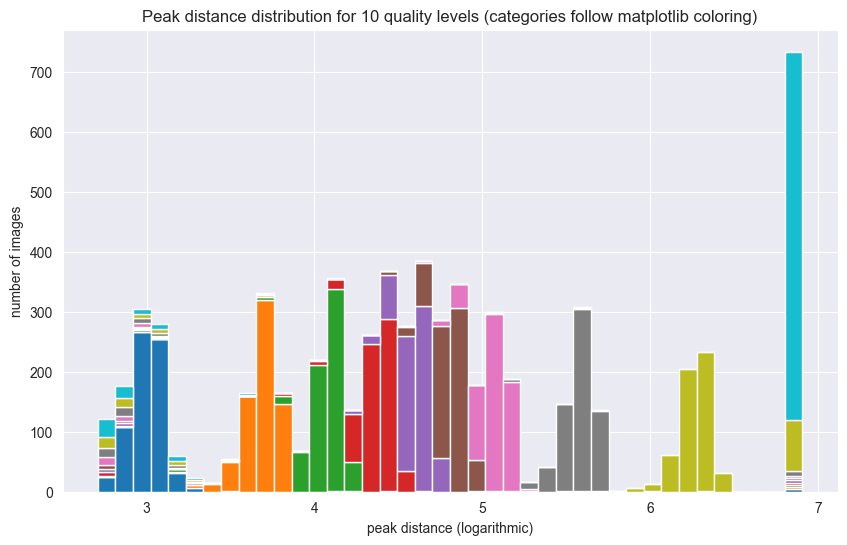

9

In [13]:
def find_bin(avg_dist):
    return np.digitize(logaritmare(avg_dist),bins)

def logaritmare(x):
    if x==0:
        x=1000
    return math.log(x)

vfunc = np.vectorize(logaritmare)

X=[np.array(vfunc(x)) for x in quality_peak_list]

plt.figure(figsize=(10, 6))

nb,bins,_ = plt.hist(X,bins=40, stacked=True ,histtype='bar',cumulative=False)

#floating point error: when an image gets a value exactly at the boundary, floating point precision might cause it to overshoot the bin
bins[-1]+=1
bins[0]-=1


plt.title("Peak distance distribution for 10 quality levels (categories follow matplotlib coloring)")
plt.xlabel("peak distance (logarithmic)")
plt.ylabel("number of images")
plt.show()


def most_likely_category(avg_dist):
    # when I get a new image see which bin it is in
    # P(cat1| bin x) = P(binx|cat1)*P(cat1) / P(binx)
    # greatest prob wins
    # p1 = nr_binx_cat1/nr_cat1 * nr_cat1/ nr_all_cat / nr_binx_total * nr_all_cat
    # p1 = nr_binx_cat1/nr_binx_total
    # since nr_binx_total is the same for all probabilities, we can just compare the number of images in each bin
    bin=find_bin(avg_dist)
    candidate_bin = nb[0][bin-1]
    ind=0
    for i in range(1,10):
        if nb[i][bin-1]-nb[i-1][bin-1] > candidate_bin:
            candidate_bin = nb[i][bin-1]-nb[i-1][bin-1]
            ind=i
    return ind+1
    

In [14]:
number_of_tests = 100
testing_cutoff = 700 # images from 700 onwards are for testing

error=0

for i in range(0, number_of_tests):
        for j in range(1, 5):
            
            file_name = f"{testing_cutoff + i + 1:04}x4w1.png"
            path = os.path.join("DIV2K_train_LR_wild", file_name)
            
            qual_cat = np.random.randint(1,11)
        
            img = compress(path, qual_cat*10)
            img = img.convert('YCbCr')
            img = zero_pad(np.array(img)[:,:,0])
            img = img.astype(np.float64)
            dct = DCT(img)[0,0,:]
            hcount, bin_edges = hist(dct)
            fft = FFT(hcount)
            _, avg_peak_dist,_ = quality(fft)
            print(avg_peak_dist)
            cat=most_likely_category(avg_peak_dist)
            print(qual_cat*10, cat*10)
            error += np.abs(cat*10-qual_cat*10)
            
            
print(f"average error: {error / number_of_tests / 4} ") # we do 4 samples for each test

85
40 40
0
100 100
63
30 30
131
60 60
147
70 70
244
80 80
55
30 30
147
70 70
603
90 90
113
50 60
91
40 50
67
30 40
129
70 60
129
70 60
129
70 60
99
60 50
506
90 90
0
100 100
151
70 70
94
50 50
558
90 90
84
40 40
168
70 70
129
60 60
269
80 80
20
10 10
60
30 30
41
20 20
0
100 100
22
10 10
67
30 40
90
40 50
140
70 70
18
10 10
0
100 100
70
40 40
102
50 50
102
50 50
546
90 90
273
80 80
29
90 20
21
10 10
42
20 20
167
70 70
0
100 100
114
60 60
114
60 60
54
30 30
0
100 100
33
20 20
0
100 100
222
80 80
232
80 80
87
50 40
69
40 40
87
50 40
268
80 80
538
90 90
20
10 10
80
40 40
60
30 30
126
60 60
0
90 100
102
50 50
18
40 10
22
10 10
21
70 10
18
60 10
17
10 10
19
30 10
19
60 10
19
30 10
39
20 20
59
30 30
23
90 10
23
100 10
121
60 60
20
10 10
37
20 20
0
100 100
63
30 30
106
50 50
63
30 30
85
40 40
38
20 20
38
20 20
75
40 40
38
20 20
138
60 70
45
20 20
299
80 80
112
50 60
122
60 60
59
30 30
122
60 60
263
80 80
96
50 50
156
70 70
78
40 40
522
90 90
52
30 30
468
90 90
108
60 50
52
30 30
0
100 100
88
4